In [3]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.pyplot import figure
import numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


datadir='/mnt/f/Tirocinio_HDD/Data/ADNI/UNIQUE_FILE.xlsx'
data=pd.read_excel(datadir,sheet_name='Tau+Amy+FDG')
#Ciao, datanoage sarebbe quella usata senza l'età, visti i cambiamenti di oggi ho preferito non cambiare i nomi,
#fai riferimento solo alla prima parte (fino al commento ####### FINE PRIMA PARTE ######) cosicchè tutto dovrebbe funzionare a prescindere da quello 
#che selezioni nel comando qui sotto
data=data[data.columns[data.columns.isin(['AGE','T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'])]]
data[data < 0] = 0 # preprocessing step, eventuali -99 values set to 0
datanoage=data

In [4]:
####### PLOT dei valori medi
def makeplots(meanvalslabel):

    numplot=1
    figure(figsize=(20, 15), dpi=100)
    for e in range(0,len(meanvalslabel.columns)):
        #print(meanvalslabel3.iloc[e])
            labl=meanvalslabel.iloc[:,e].name+" \nValue = "+str(meanvalslabel.iloc[:,e].values[0])
            values=meanvalslabel.iloc[:,e]
            #print(labl)
            plt.subplot(4,4,numplot)
            plt.plot(values,'P',label=labl,color=numpy.random.rand(3,))
            plt.legend()
            numplot+=1

    plt.show()

In [5]:
################## MEAN VALUES ###########
def meanvalues(dat):
    
    df=pd.DataFrame(columns=dat.columns)
    tmp=[]
    for col in range(0,len(dat.columns)):
        dato=dat.iloc[:,col].mean()
        
        tmp.append(dato)
    pos=0    
    for col in range(0,len(dat.columns)):
        #df.iloc[:,col]=tmp[pos]
        name=dat.iloc[:,col].name
        df.at[1,name]=tmp[pos]
                     
        pos+=1
    return df

In [324]:
len(data.columns)

11

In [325]:
#quanti per classe
dataclass=pd.read_excel(datadir,sheet_name='Tau+Amy+FDG')
EMCI=0
AD=0
CN=0
LMCI=0
for i in range(0,len(dataclass)):
    if dataclass.iloc[i]['ADNIMERGE']=='EMCI' :
        EMCI+=1
    if dataclass.iloc[i]['ADNIMERGE']=='AD' :
        AD+=1
    if dataclass.iloc[i]['ADNIMERGE']=='CN' :
        CN+=1
    if dataclass.iloc[i]['ADNIMERGE']=='LMCI' :
        LMCI+=1

        
vect=[EMCI,AD,CN,LMCI]
print(vect)

[48, 17, 38, 34]


In [26]:
datanoage

,ABETA,TAU,PTAU,A_COMPOSITE_SUVR,A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,A_NORM_CTX_ENTORHINAL_SUVR,A_NORM_AMYGDALA_SUVR,A_NORM_HIPPOCAMPUS_SUVR,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
0,688.9,394.0,40.35,1.8664,1.100889,0.613641,0.703225,0.666256,1.493576,1.308446,1.710615,1.790227,1.531171,1.042618,0.001760,0.000655,0.000469,0.003433
1,1286.0,186.9,14.14,1.8474,0.667858,0.642308,0.636949,0.639710,1.240267,1.079087,1.219323,1.296168,1.356808,1.144017,0.001863,0.001093,0.001091,0.004246
2,866.2,335.9,33.43,1.8596,1.236018,0.710368,0.825823,0.796569,1.634722,2.383952,1.466140,1.295301,1.307511,0.790032,0.002673,0.001198,0.001332,0.002352
3,599.9,319.6,31.80,1.5173,1.122191,0.696962,0.821196,0.716009,1.376690,1.174672,1.455197,1.685974,1.291726,1.111146,0.001984,0.000700,0.000865,0.003004
4,422.0,393.0,41.88,1.6777,1.059844,0.682601,0.859510,0.776003,1.225971,0.966595,1.412235,1.678041,1.379752,1.165156,0.002096,0.000803,0.000865,0.003504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,1700.0,287.6,25.56,1.0192,0.863043,0.914543,0.916674,0.934536,1.328133,1.001956,1.561577,1.425218,1.334344,1.012133,0.002094,0.000843,0.000652,0.003502
133,1218.0,167.0,15.60,1.1717,0.956588,0.862477,0.948825,1.048747,1.159273,0.944768,1.117272,1.182168,1.207093,1.138825,0.002207,0.000806,0.001201,0.003076
134,1297.0,189.4,16.36,1.2618,1.120027,0.898300,1.106125,1.227600,0.988224,0.831294,0.995560,1.034976,1.048403,1.174329,0.001989,0.000865,0.000874,0.002505
135,1042.0,133.2,11.20,0.9711,0.999849,0.837366,0.876084,0.870841,1.068805,1.036390,1.021386,1.007726,0.983540,1.286921,0.002057,0.001044,0.001126,0.003989


In [326]:
## KMEANS

## 4 Cluster
#X:{array-like, sparse matrix} of shape (n_samples, n_features)

kmeans2 = KMeans(n_clusters=4, random_state=None,max_iter=500,n_init=50).fit_predict(datanoage)

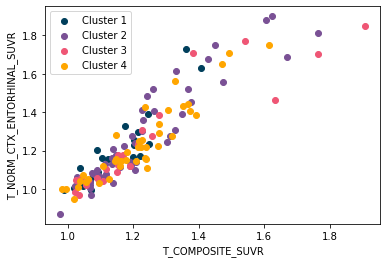

In [327]:
# columns to plot
col1=1
col2=3

color1='#003f5c'
color2='#7a5195'
color3='#ef5675'
color4='#ffa600'
#filter rows of original data
filtered_label0 = datanoage[kmeans2 == 0]
filtered_label1 = datanoage[kmeans2 == 1]
filtered_label2 = datanoage[kmeans2 == 2]
filtered_label3 = datanoage[kmeans2 == 3]
#plotting the results
plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)
plt.scatter(filtered_label3.iloc[:,col1] , filtered_label3.iloc[:,col2],label='Cluster 4',color=color4)



plt.xlabel(datanoage.columns[col1])
plt.ylabel(datanoage.columns[col2])

plt.legend()
plt.show()

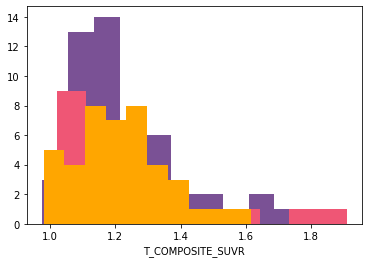

In [328]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)
plt.hist(filtered_label3.iloc[:,col1],label='Cluster 4',color=color4)
plt.xlabel(datanoage.columns[col1])
plt.show()

In [329]:
datanoage.columns

Index(['AGE', 'T_COMPOSITE_SUVR', 'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR',
       'T_NORM_CTX_ENTORHINAL_SUVR', 'T_NORM_AMYGDALA_SUVR',
       'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN', 'N_HIPPOCAMPUS_VOLUME',
       'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')

In [333]:
## KMEANS

## 3 Cluster
kmeans2 = KMeans(n_clusters=3, random_state=None,max_iter=500,n_init=50).fit_predict(datanoage)

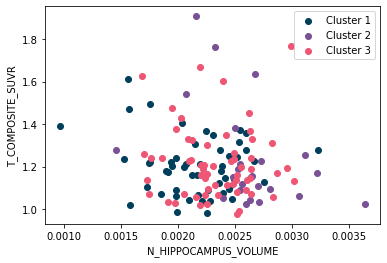

In [334]:
#filter rows of original data
filtered_label0 = datanoage[kmeans2 == 0]
filtered_label1 = datanoage[kmeans2 == 1]
filtered_label2 = datanoage[kmeans2 == 2]

# columns to plot
col1=7
col2=1


color1='#003f5c'
color2='#7a5195'
color3='#ef5675'


#plotting the results
plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)



plt.xlabel(datanoage.columns[col1])
plt.ylabel(datanoage.columns[col2])
plt.legend()
plt.show()

In [147]:
datanoage.columns

Index(['AGE', 'T_COMPOSITE_SUVR', 'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR',
       'T_NORM_CTX_ENTORHINAL_SUVR', 'T_NORM_AMYGDALA_SUVR',
       'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN', 'N_HIPPOCAMPUS_VOLUME',
       'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')

In [335]:
meanvalslabel1=meanvalues(filtered_label0)
meanvalslabel2=meanvalues(filtered_label1)
meanvalslabel3=meanvalues(filtered_label2)





In [336]:
meanvalslabel3

,AGE,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
1,73.5,1.215005,1.080496,1.25093,1.322548,1.295168,1.210362,0.002338,0.000975,0.001127,0.003645


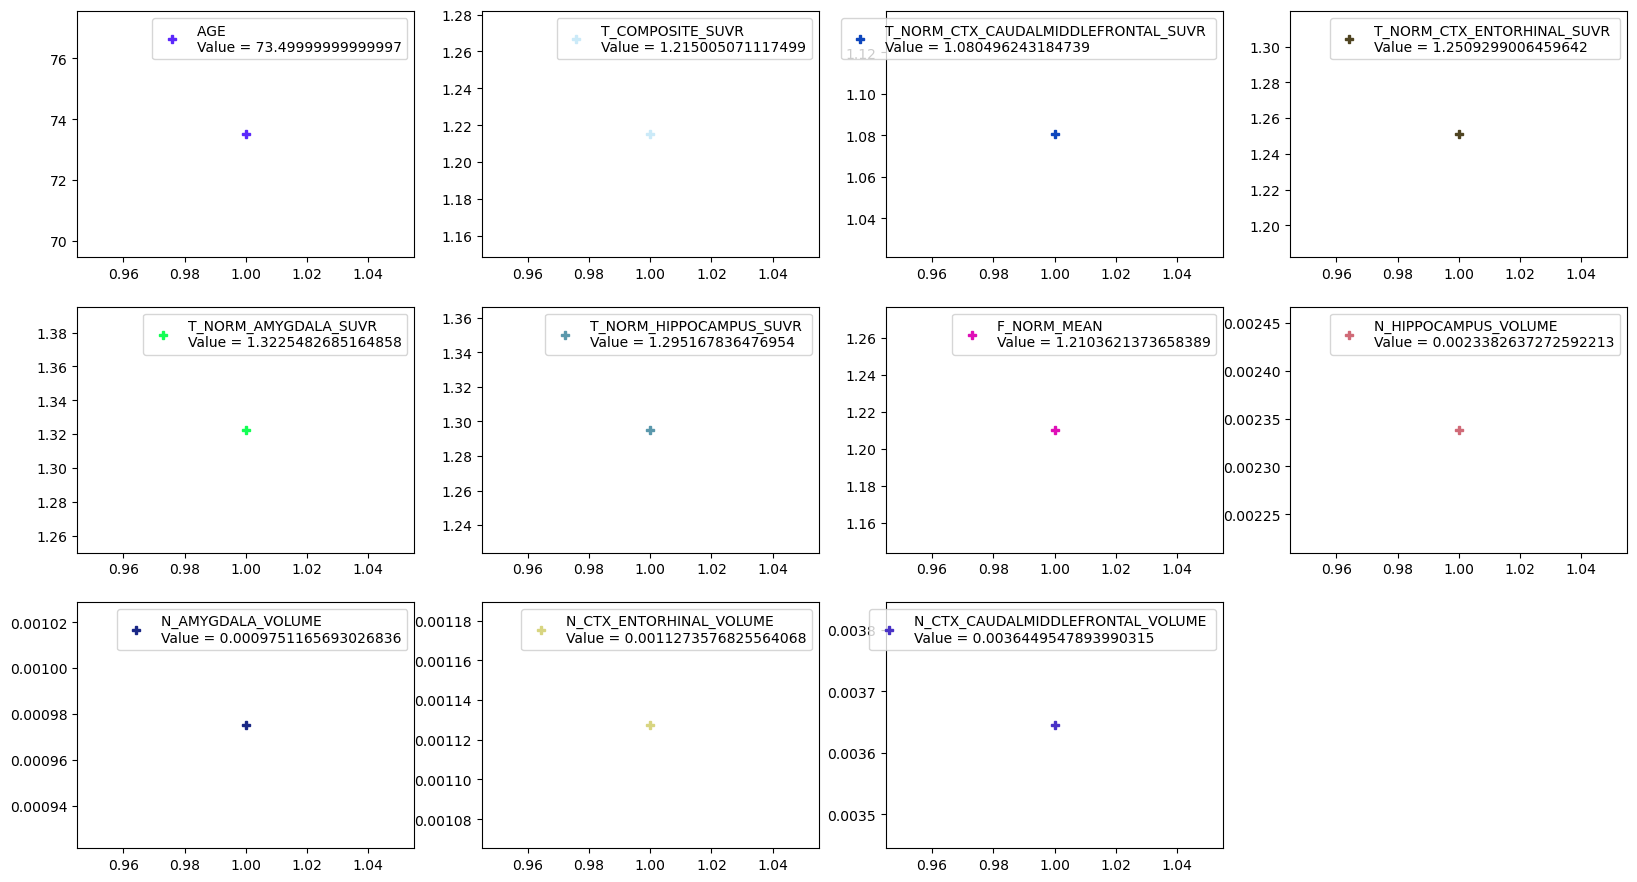

In [342]:
makeplots(meanvalslabel3)

In [314]:
meanvalslabel2

,AGE,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
1,61.908333,1.236132,1.224433,1.240389,1.270565,1.246905,1.231302,0.002615,0.001103,0.001185,0.003814


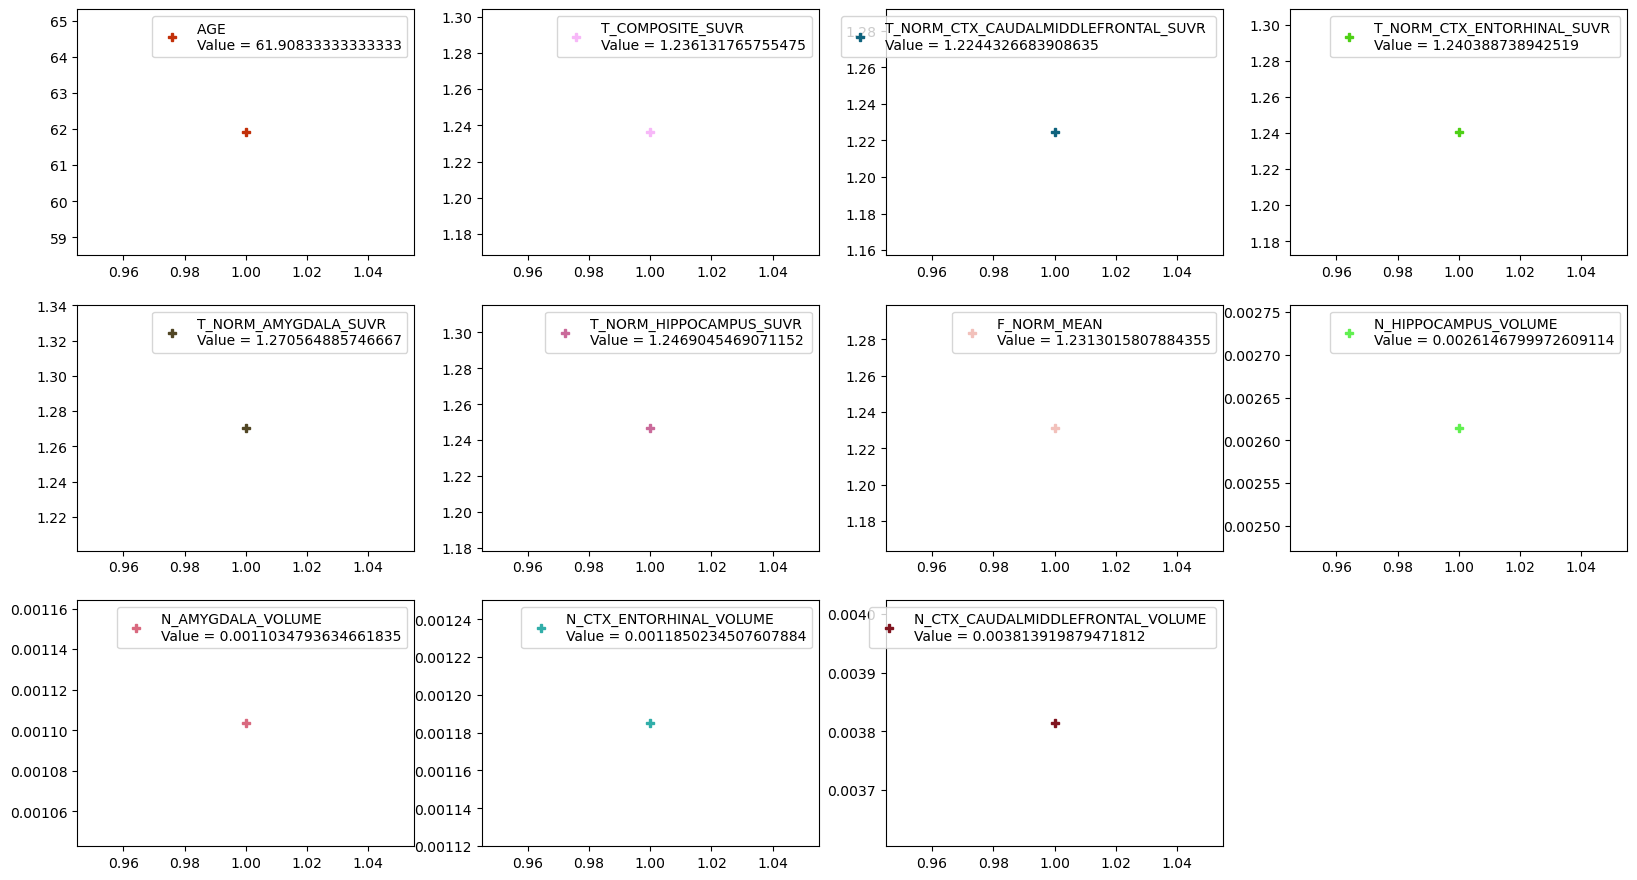

In [343]:
makeplots(meanvalslabel2)

In [344]:
meanvalslabel1

,AGE,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
1,85.443396,1.201658,1.066665,1.236874,1.320881,1.302338,1.216717,0.002163,0.000887,0.001098,0.003501


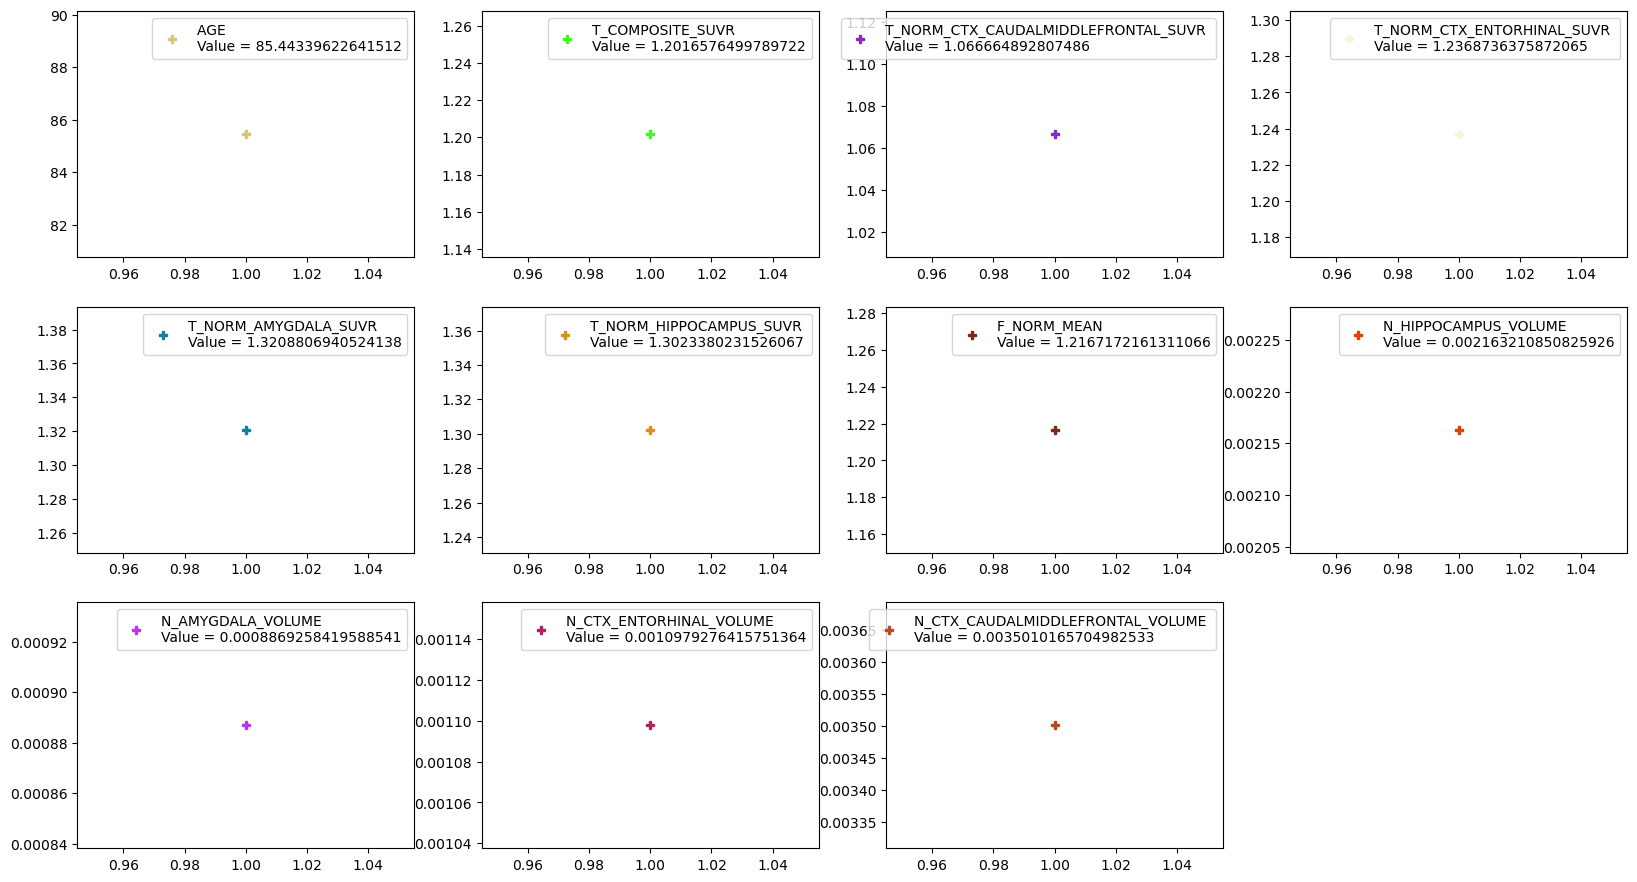

In [345]:
makeplots(meanvalslabel1)

In [296]:
X

,ABETA,TAU,PTAU,A_COMPOSITE_SUVR,A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,A_NORM_CTX_ENTORHINAL_SUVR,A_NORM_AMYGDALA_SUVR,A_NORM_HIPPOCAMPUS_SUVR,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
0,688.9,394.0,40.35,1.8664,1.100889,0.613641,0.703225,0.666256,1.493576,1.308446,1.710615,1.790227,1.531171,1.042618,0.001760,0.000655,0.000469,0.003433
1,1286.0,186.9,14.14,1.8474,0.667858,0.642308,0.636949,0.639710,1.240267,1.079087,1.219323,1.296168,1.356808,1.144017,0.001863,0.001093,0.001091,0.004246
2,866.2,335.9,33.43,1.8596,1.236018,0.710368,0.825823,0.796569,1.634722,2.383952,1.466140,1.295301,1.307511,0.790032,0.002673,0.001198,0.001332,0.002352
3,599.9,319.6,31.80,1.5173,1.122191,0.696962,0.821196,0.716009,1.376690,1.174672,1.455197,1.685974,1.291726,1.111146,0.001984,0.000700,0.000865,0.003004
4,422.0,393.0,41.88,1.6777,1.059844,0.682601,0.859510,0.776003,1.225971,0.966595,1.412235,1.678041,1.379752,1.165156,0.002096,0.000803,0.000865,0.003504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,1700.0,287.6,25.56,1.0192,0.863043,0.914543,0.916674,0.934536,1.328133,1.001956,1.561577,1.425218,1.334344,1.012133,0.002094,0.000843,0.000652,0.003502
133,1218.0,167.0,15.60,1.1717,0.956588,0.862477,0.948825,1.048747,1.159273,0.944768,1.117272,1.182168,1.207093,1.138825,0.002207,0.000806,0.001201,0.003076
134,1297.0,189.4,16.36,1.2618,1.120027,0.898300,1.106125,1.227600,0.988224,0.831294,0.995560,1.034976,1.048403,1.174329,0.001989,0.000865,0.000874,0.002505
135,1042.0,133.2,11.20,0.9711,0.999849,0.837366,0.876084,0.870841,1.068805,1.036390,1.021386,1.007726,0.983540,1.286921,0.002057,0.001044,0.001126,0.003989


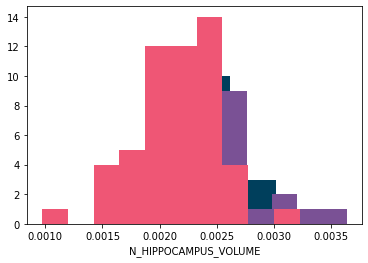

In [139]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)
plt.xlabel(datanoage.columns[col1])
plt.show()

In [ ]:
####### FINE PRIMA PARTE ######                 ####### FINE PRIMA PARTE ######           

In [16]:
## 2 version, W AGE

In [17]:

dataage=pd.read_excel(datadir,sheet_name='Tau+Amy+FDG')
dataage=dataage[dataage.columns[dataage.columns.isin(['AGE','ABETA','PTAU','TAU','A_COMPOSITE_SUVR','A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'A_NORM_CTX_ENTORHINAL_SUVR',
       'A_NORM_AMYGDALA_SUVR', 'A_NORM_HIPPOCAMPUS_SUVR', 'T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'])]]
dataage[dataage < 0] = 0 #-99 set to 0
#X:{array-like, sparse matrix} of shape (n_samples, n_features)
print(dataage.columns)


Index(['AGE', 'ABETA', 'TAU', 'PTAU', 'A_COMPOSITE_SUVR',
       'A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'A_NORM_CTX_ENTORHINAL_SUVR',
       'A_NORM_AMYGDALA_SUVR', 'A_NORM_HIPPOCAMPUS_SUVR', 'T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')


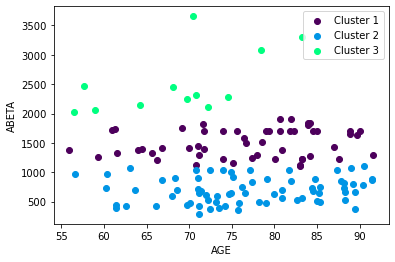

In [18]:

kmeans2 = KMeans(n_clusters=3, random_state=None,max_iter=500,n_init=50).fit_predict(dataage)
#filter rows of original data
filtered_label0 = dataage[kmeans2 == 0]
filtered_label1 = dataage[kmeans2 == 1]
filtered_label2 = dataage[kmeans2 == 2]

# columns to plot
col1=0
col2=1

color1='#4d005c'
color2='#0095e5'
color3='#00ff80'
#plotting the results
plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)


plt.xlabel(dataage.columns[col1])
plt.ylabel(dataage.columns[col2])

plt.legend()
plt.show()

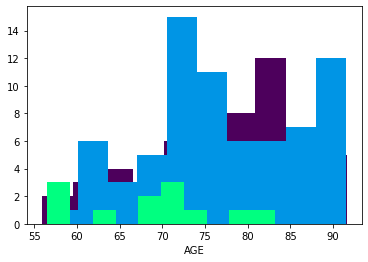

In [19]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)
plt.xlabel(dataage.columns[col1])
plt.show()

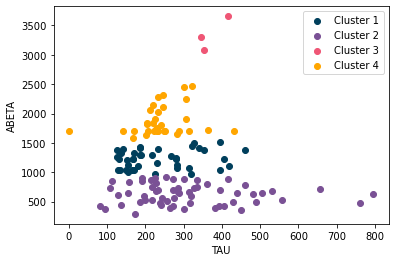

In [20]:

kmeans2 = KMeans(n_clusters=4, random_state=None,max_iter=500,n_init=50).fit_predict(dataage)
#filter rows of original data
filtered_label0 = dataage[kmeans2 == 0]
filtered_label1 = dataage[kmeans2 == 1]
filtered_label2 = dataage[kmeans2 == 2]
filtered_label3 = dataage[kmeans2 == 3]

# columns to plot
col1=2
col2=1

color1='#003f5c'
color2='#7a5195'
color3='#ef5675'
color4='#ffa600'
#plotting the results

plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)
plt.scatter(filtered_label3.iloc[:,col1] , filtered_label3.iloc[:,col2],label='Cluster 4',color=color4)



plt.xlabel(dataage.columns[col1])
plt.ylabel(dataage.columns[col2])

plt.legend()
plt.show()

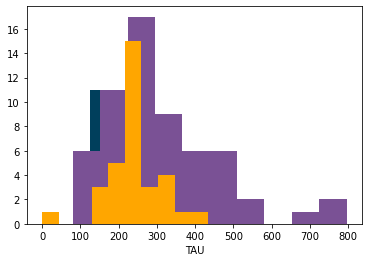

In [21]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)
plt.hist(filtered_label3.iloc[:,col1],label='Cluster 4',color=color4)
plt.xlabel(dataage.columns[col1])
plt.show()

In [22]:
filtered_label0

,AGE,ABETA,TAU,PTAU,A_COMPOSITE_SUVR,A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,A_NORM_CTX_ENTORHINAL_SUVR,A_NORM_AMYGDALA_SUVR,A_NORM_HIPPOCAMPUS_SUVR,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
1,78.0,1286.0,186.9,14.14,1.8474,0.667858,0.642308,0.636949,0.639710,1.240267,1.079087,1.219323,1.296168,1.356808,1.144017,0.001863,0.001093,0.001091,0.004246
6,74.9,1007.0,155.6,12.81,1.7893,0.669591,0.583748,0.636897,0.616051,1.026279,0.927557,1.062317,1.097182,1.040814,1.037125,0.001976,0.000804,0.000854,0.003119
13,60.4,969.9,319.9,27.86,1.5246,0.762036,0.492457,0.603306,0.670405,1.279337,1.101441,1.388155,1.486495,1.247399,1.024619,0.001458,0.000482,0.000460,0.003668
17,70.8,1034.0,127.2,10.03,1.7318,0.670285,0.582920,0.614274,0.644532,1.135791,1.062310,1.162278,1.059687,1.209798,1.081969,0.002610,0.000981,0.001202,0.003829
19,74.0,1037.0,169.5,14.39,1.7784,0.741228,0.656883,0.742578,0.709514,1.067119,0.964134,1.008396,1.096610,1.219032,1.020671,0.002354,0.001123,0.001043,0.003712
20,61.5,1333.0,136.9,12.18,1.5142,0.723616,0.668670,0.732466,0.790516,1.153682,1.020749,1.175244,1.138426,1.209418,1.397788,0.002648,0.001273,0.001191,0.004094
26,75.1,1149.0,231.0,20.50,1.8314,0.861199,0.578246,0.667194,0.751502,1.303604,1.122277,1.246487,1.402158,1.479230,1.217452,0.002253,0.000809,0.000932,0.003685
27,59.3,1263.0,125.6,9.99,1.4926,0.758743,0.672183,0.679284,0.759212,1.089725,1.051801,1.058898,1.149258,1.118856,1.283360,0.002543,0.001184,0.001015,0.003662
30,56.6,975.4,224.1,19.44,1.6753,0.687161,0.680714,0.719632,0.869755,1.060979,0.965876,1.049369,1.118425,1.112367,1.300325,0.003065,0.001346,0.001001,0.004803
31,70.8,1118.0,155.5,13.63,1.5592,0.744741,0.716072,0.714982,0.811378,1.134530,1.081166,1.128645,1.108255,1.218676,1.217778,0.003018,0.001262,0.001717,0.004376


For n_clusters = 3 The average silhouette_score is : 0.5410756191680103
For n_clusters = 4 The average silhouette_score is : 0.5241132166035362
For n_clusters = 5 The average silhouette_score is : 0.5230296193308933


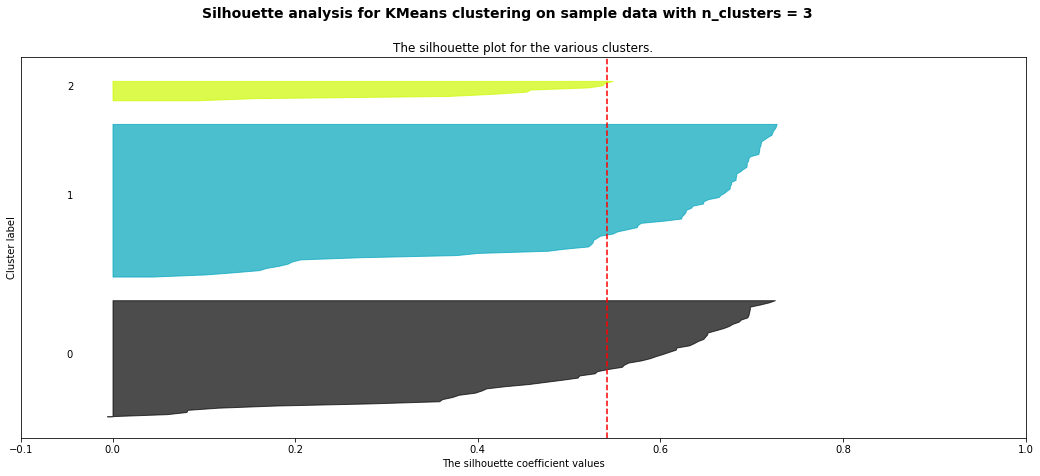

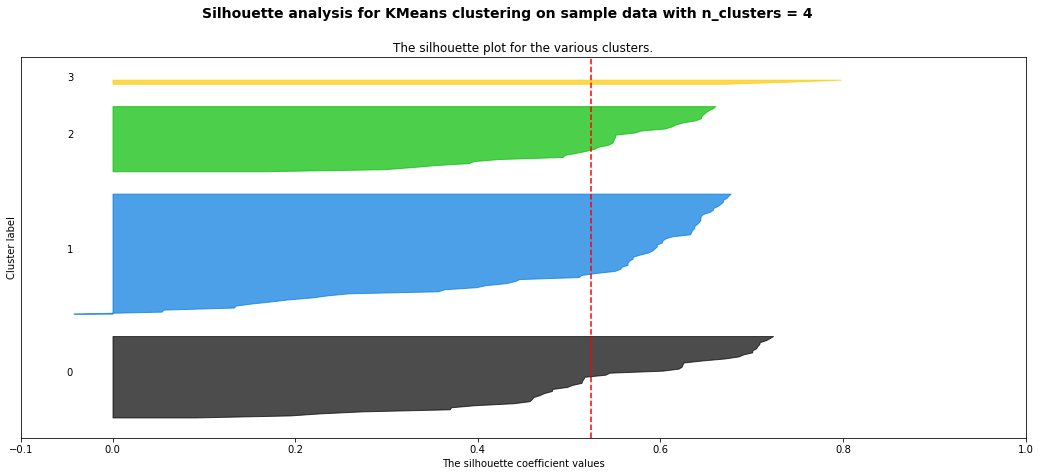

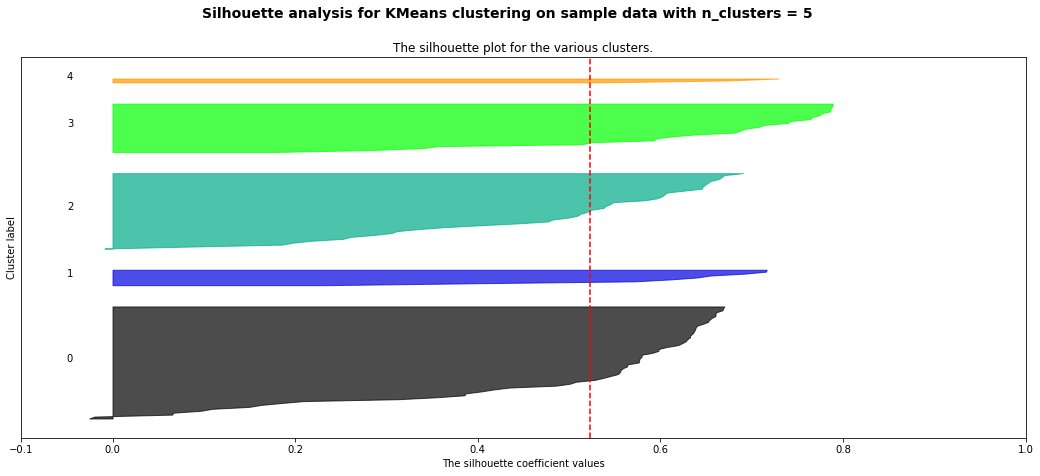

In [6]:
range_n_clusters = [3, 4, 5]
X=data

for n_clusters in range_n_clusters:
 
    fig, (ax1) = plt.subplots(1,1 )
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])



    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=None).fit(X)
    cluster_labels=kmeans.labels_
    centers= kmeans.cluster_centers_
    
   # cluster_labels = KMeans(n_clusters=n_clusters, random_state=None).fit_predict(X) #equivalent to calling fit(X) and after predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
   
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )


plt.savefig('My_silhouette.png')
plt.show()

In [133]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.pyplot import figure
import numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import NMF
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler


datadir='/mnt/f/Tirocinio_HDD/Data/ADNI/UNIQUE_FILE.xlsx'
data=pd.read_excel(datadir,sheet_name='Tau+Amy+FDG')
"""
data=data[data.columns[data.columns.isin(['T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'])]]
       """



In [134]:
data=data.drop(['AGE','ID','ADNIMERGE','ACQUISITION DATE','SEX','EXAMDATE','DIFF DATE','fMRI Volumes','AV45','AV1451','FBB','FDG','VOLUMES','RID'],axis=1)
scaler=MinMaxScaler()
datas=scaler.fit_transform(data)

In [52]:
datas

array([[0.5552439 , 0.23792319, 0.81636446, ..., 0.2678497 , 0.13444517,
        0.59699862],
       [0.28311378, 0.12355749, 0.33895133, ..., 0.63243583, 0.5493871 ,
        0.82672076],
       [0.70687674, 0.77420549, 0.57879564, ..., 0.71995536, 0.7104502 ,
        0.29153052],
       ...,
       [0.01234409, 0.        , 0.12150955, ..., 0.44317548, 0.40470226,
        0.33470689],
       [0.09891242, 0.10226753, 0.1466058 , ..., 0.59179522, 0.57238396,
        0.75384005],
       [0.28444075, 0.11863858, 0.23475543, ..., 0.27830074, 0.21933485,
        0.6255266 ]])

In [57]:
np.max(datas)

1.0000000000000002

In [139]:
model = NMF(n_components=6, init='random', random_state=0)

W = model.fit_transform(datas)

H = model.components_

In [140]:
H.shape

(6, 18)

In [141]:
W.shape


(137, 6)

In [135]:
from sklearn.metrics import explained_variance_score
from sklearn import decomposition
def get_score(model, data, scorer=explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data))
    return scorer(data, prediction)


In [136]:
ks = [1,2,3,4,5,6,7,8,9,10]
perfs_test = []
for k in ks:
    nmf = decomposition.NMF(n_components=k, max_iter=100000).fit(datas)
    perfs_test.append(get_score(nmf, datas))

print(perfs_test)


/home/duetochance/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/duetochance/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/duetochance/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/duetochance/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nm

[0.10595643662701877, 0.32937249781111255, 0.5907833268187657, 0.6525662072281005, 0.7363344064303438, 0.7885170518623219, 0.841392162980526, 0.8899975429427582, 0.9158915664176472, 0.9385164217788444]


In [94]:
len(data.columns)

10

In [145]:
data.columns

Index(['ABETA', 'TAU', 'PTAU', 'A_COMPOSITE_SUVR',
       'A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'A_NORM_CTX_ENTORHINAL_SUVR',
       'A_NORM_AMYGDALA_SUVR', 'A_NORM_HIPPOCAMPUS_SUVR', 'T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')

10

<AxesSubplot:>

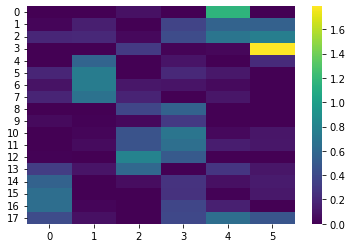

In [142]:
sn.heatmap(H.T,cmap='viridis')

<AxesSubplot:>

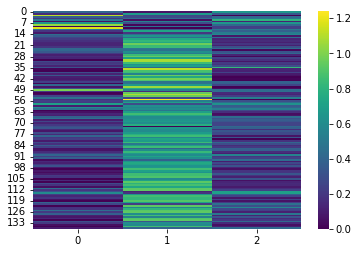

In [70]:
sn.heatmap(W,cmap='viridis')

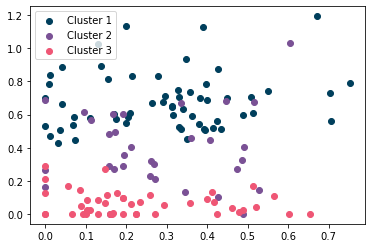

In [143]:
kmeans2 = KMeans(n_clusters=3, random_state=None,max_iter=500,n_init=50).fit_predict(W)
#filter rows of original data
filtered_label0 = W[kmeans2 == 0]
filtered_label1 = W[kmeans2 == 1]
filtered_label2 = W[kmeans2 == 2]
#filtered_label3 = dataage[kmeans2 == 3]

# columns to plot
col1=2
col2=1

color1='#003f5c'
color2='#7a5195'
color3='#ef5675'
#color4='#ffa600'
#plotting the results

plt.scatter(filtered_label0[:,col1] , filtered_label0[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1[:,col1] , filtered_label1[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color3)
#plt.scatter(filtered_label3.iloc[:,col1] , filtered_label3.iloc[:,col2],label='Cluster 4',color=color4)




plt.legend()
plt.show()

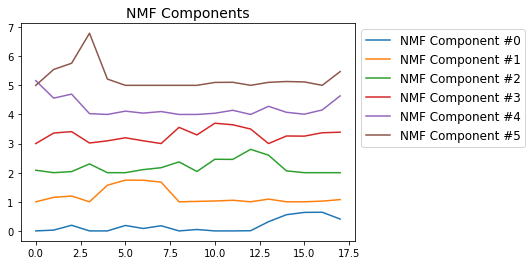

In [144]:
fig, axis = plt.subplots()
for comp_ind, end_member in enumerate(model.components_):
    axis.plot(end_member + comp_ind * 1, 
              label = 'NMF Component #' + str(comp_ind))
#axis.set_xlabel(x_label, fontsize=12)
#axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0,1.0], fontsize=12);


In [80]:
model.components_

array([[0.60277235, 0.5038889 , 0.58199074, 0.40826299, 0.39372105,
        0.        , 0.42725584, 0.41983595, 0.52662747, 0.        ],
       [0.        , 0.0213209 , 0.02128015, 0.06089182, 0.08105823,
        0.57748668, 0.60691462, 0.65317937, 0.68881379, 0.66947099],
       [0.45636154, 0.        , 0.81342363, 0.92619232, 0.8422419 ,
        0.42861785, 0.03062962, 0.        , 0.        , 0.78353347]])

In [ ]:
############# OFFICIAL #######

In [1]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.pyplot import figure
import numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import explained_variance_score
from sklearn import decomposition
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import math
import sys

datadir='/mnt/f/Tirocinio_HDD/Data/ADNI/UNIQUE_FILE.xlsx'
data=pd.read_excel(datadir,sheet_name='Tau+FDG')
datanoage=pd.read_excel(datadir,sheet_name='Tau+FDG')

data=data[data.columns[data.columns.isin(['AGE','T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'])]] 


datanoage=datanoage[datanoage.columns[datanoage.columns.isin(['T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'])]] 
 



data[data < 0] = 0 # preprocessing step, eventuali -99 values set to 0
datanoage[datanoage < 0] = 0 # preprocessing step, eventuali -99 values set to 0
scaler=MinMaxScaler()
datas=scaler.fit_transform(data)
datanoages=scaler.fit_transform(datanoage)


In [13]:
print("DATA:\n" + str(data.columns)+"\t length: "+str(len(data)))
print("DATA (no age) :\n" +str(datanoage.columns)+"\t length: "+str(len(datanoage)))


DATA:
Index(['AGE', 'T_COMPOSITE_SUVR', 'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR',
       'T_NORM_CTX_ENTORHINAL_SUVR', 'T_NORM_AMYGDALA_SUVR',
       'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN', 'N_HIPPOCAMPUS_VOLUME',
       'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')	 length: 299
DATA (no age) :
Index(['T_COMPOSITE_SUVR', 'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR',
       'T_NORM_CTX_ENTORHINAL_SUVR', 'T_NORM_AMYGDALA_SUVR',
       'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN', 'N_HIPPOCAMPUS_VOLUME',
       'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')	 length: 299


In [3]:
def get_score(model, data, scorer=explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data))
    return scorer(data, prediction)

In [24]:
#data
ks = [1,2,3,4,5]
perfs_test = []
for k in ks:
    nmf = decomposition.NMF(n_components=k,init='nndsvda', max_iter=500000).fit(datas)
    perfs_test.append(get_score(nmf, datas))

print(perfs_test)

[0.1565498164269852, 0.5777338837268708, 0.7194821593523959, 0.7971949960522878, 0.865731935905746]


/home/duetochance/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [25]:
#datanoage
ks = [1,2,3,4,5,6,7,8]
perfs_test = []
for k in ks:
    nmf = decomposition.NMF(n_components=k,init='nndsvda', max_iter=500000).fit(datanoages)
    perfs_test.append(get_score(nmf, datanoages))

print(perfs_test)

/home/duetochance/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


[0.21826871160943476, 0.6830947483987566, 0.7699226495409338, 0.8483193027649225, 0.9118251279262356, 0.9516800143452055, 0.9716277964111224, 0.9881816312329864]


In [55]:
ncompage=5
model_age = NMF(n_components=ncompage, init='nndsvda', random_state=0,max_iter=500000)
W_age = model_age .fit_transform(datas)
H_age = model_age .components_

In [67]:
ncompnoage=4
model_noage = NMF(n_components=ncompnoage, init='nndsvda', random_state=0,max_iter=500000)
W_noage = model_noage .fit_transform(datanoages)
H_noage = model_noage .components_

In [57]:
##PLOTS

In [58]:
#W age

<AxesSubplot:>

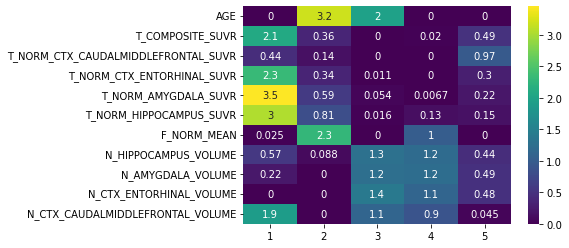

In [61]:

sn.heatmap(H_age.T,cmap='viridis',annot=True, yticklabels=data.columns,xticklabels=range(1, ncompage+1))

In [62]:
#Wo age

<AxesSubplot:>

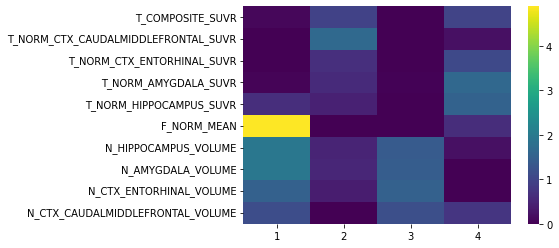

In [68]:
sn.heatmap(H_noage.T,cmap='viridis',yticklabels=datanoage.columns,xticklabels=range(1, ncompnoage+1))

In [90]:
#Kmeans
color1='#003f5c'
color2='#7a5195'
color3='#ef5675'
color4='#ba8f45'
color5='#ffa600'
color6='#c4503b'
color7='#943bc4'
color8='#6bc43b'

In [96]:
#Wo Age
#ncompnoage=8 al momento
kmeans_noage = KMeans(n_clusters=4, random_state=None,max_iter=1000,n_init=50).fit_predict(W_noage)

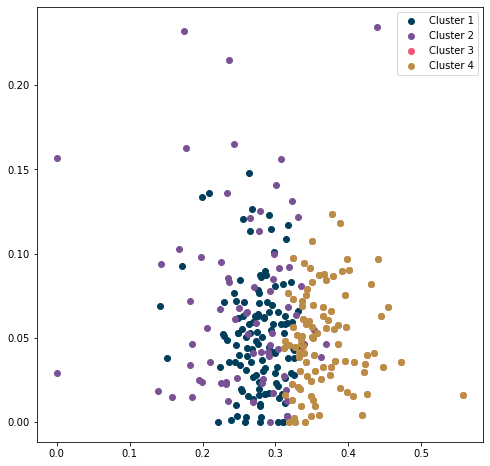

In [97]:
#filter rows of original dataW_noage 
filtered_label0 = W_noage [kmeans_noage == 0]
filtered_label1 = W_noage [kmeans_noage == 1]
filtered_label2 = W_noage [kmeans_noage == 2]
filtered_label3 = W_noage [kmeans_noage == 3]
#filtered_label4 = W_noage[kmeans_noage == 4]
#filtered_label5 = W_noage[kmeans_noage == 5]
#filtered_label6 = W_noage[kmeans_noage == 6]
#filtered_label7 = W_noage[kmeans_noage == 7]



# columns to plot
col1=2
col2=1


#color4='#ffa600'
#plotting the results
plt.figure(figsize=(8,8))

plt.scatter(filtered_label0[:,col1] , filtered_label0[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1[:,col1] , filtered_label1[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color3)
plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 4',color=color4)
#plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 5',color=color5)
#plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 6',color=color6)
#plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 7',color=color7)
#plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 8',color=color8)





plt.legend()
plt.show()

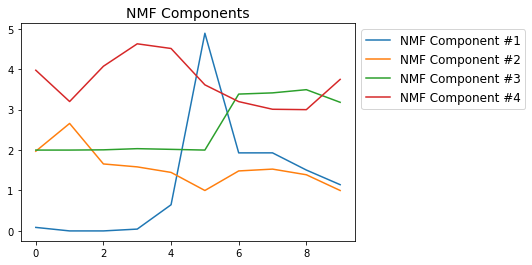

In [98]:
fig, axis = plt.subplots()
for comp_ind, end_member in enumerate(model_noage .components_):
    axis.plot(end_member + comp_ind * 1, 
              label = 'NMF Component #' + str(comp_ind+1))
#axis.set_xlabel(x_label, fontsize=12)
#axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0,1.0], fontsize=12);

In [99]:
#W Age

kmeans_age = KMeans(n_clusters=5, random_state=None,max_iter=1000,n_init=50).fit_predict(W_age)

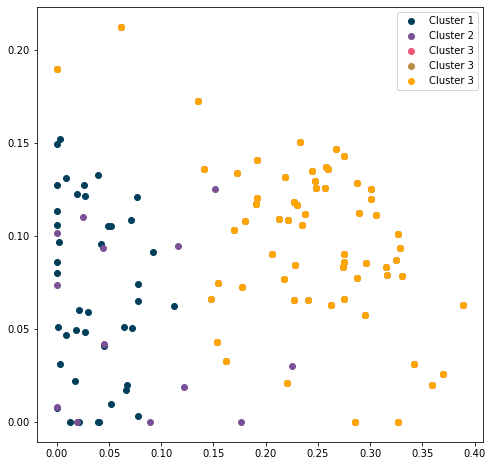

In [100]:
#filter rows of original data
filtered_label0 = W_age[kmeans_age == 0]
filtered_label1 = W_age[kmeans_age == 1]
filtered_label2 = W_age[kmeans_age == 2]
filtered_label3 = W_age[kmeans_age == 3]
filtered_label4 = W[kmeans_age == 4]
#filtered_label5 = W[kmeans_age == 5]
#filtered_label6 = W[kmeans_age == 6]
#filtered_label7 = W[kmeans_age == 7]
#filtered_label8 = W[kmeans_age == 8]

# columns to plot
col1=2
col2=1




#plotting the results
plt.figure(figsize=(8,8))
plt.scatter(filtered_label0[:,col1] , filtered_label0[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1[:,col1] , filtered_label1[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color3)
plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color4)
plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color5)
#plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color6)
#plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color7)
#plt.scatter(filtered_label2[:,col1] , filtered_label2[:,col2],label='Cluster 3',color=color8)




plt.legend()
plt.show()

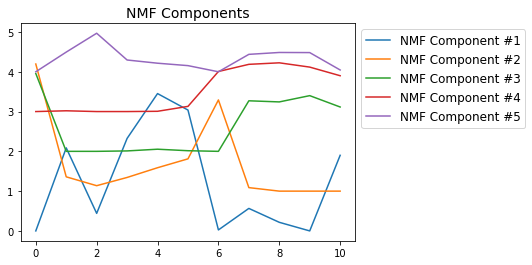

In [101]:
fig, axis = plt.subplots()
for comp_ind, end_member in enumerate(model_age .components_):
    axis.plot(end_member + comp_ind * 1, 
              label = 'NMF Component #' + str(comp_ind+1))
#axis.set_xlabel(x_label, fontsize=12)
#axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0,1.0], fontsize=12);